In [4]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
data=pd.read_csv('/kaggle/input/covid-19-fatalities-data/data_global_data.csv')
data.sample(20)

,country,date,deaths,daily_deaths
69738,Gabon,09/13/20,53,0.0
72874,Germany,05/14/20,7723,89.0
55662,Dominica,10/25/20,0,0.0
149916,Panama,03/11/20,1,1.0
113625,Liechtenstein,12/04/21,62,0.0
190224,Taiwan*,07/15/20,7,0.0
6177,Antarctica,02/08/22,0,0.0
142061,Nicaragua,06/22/22,241,0.0
141631,Nicaragua,04/18/21,180,0.0
107523,Latvia,02/01/20,0,0.0


# EDA

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218286 entries, 0 to 218285
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   country       218286 non-null  object 
 1   date          218286 non-null  object 
 2   deaths        218286 non-null  int64  
 3   daily_deaths  218286 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.7+ MB


In [13]:
data['date'] = pd.to_datetime(data['date'])

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day


KeyboardInterrupt: 

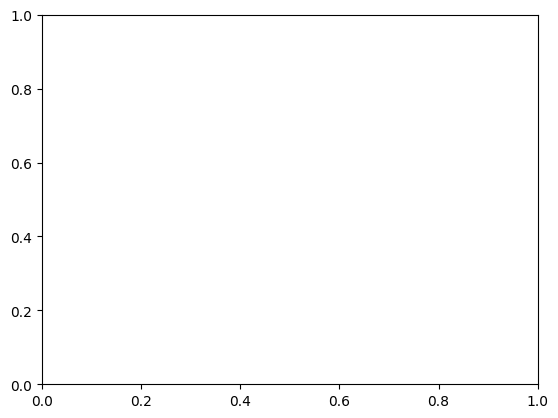

In [14]:
sns.histplot(data['deaths'], bins=50, kde=True, color='blue')
plt.title("Distribution of Total Deaths")
plt.show()

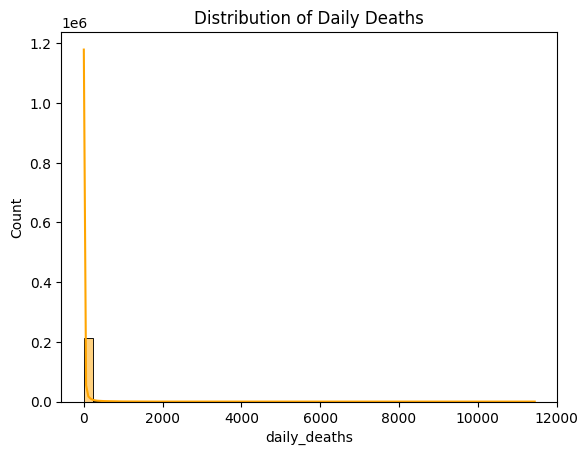

In [15]:
sns.histplot(data['daily_deaths'], bins=50, kde=True, color='orange')
plt.title("Distribution of Daily Deaths")
plt.show()

In [16]:
country_deaths = data.groupby('country')['deaths'].sum().sort_values(ascending=False)
sorted_country_by_death=pd.DataFrame(country_deaths)
sorted_country_by_death.head(20)

,deaths
country,
US,651646792
Brazil,449117129
India,335199171
Mexico,222467225
Russia,199285906
Peru,158480064
United Kingdom,148411716
Italy,117447963
France,104144561


country
US                651646792
Brazil            449117129
India             335199171
Mexico            222467225
Russia            199285906
Peru              158480064
United Kingdom    148411716
Italy             117447963
France            104144561
Colombia           92707186
Name: deaths, dtype: int64


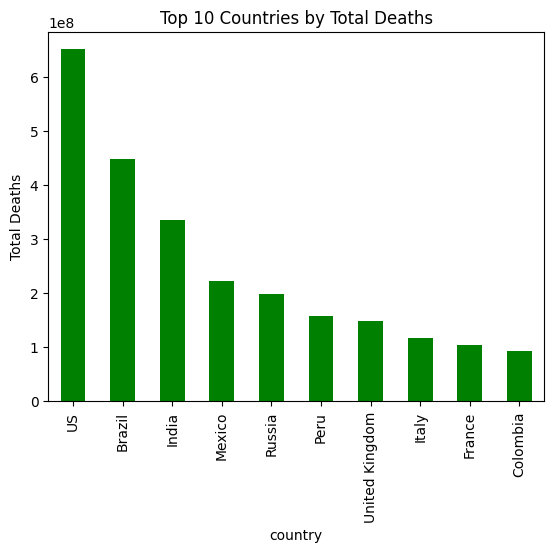

In [17]:
top_countries = country_deaths.head(10)
print(top_countries)

# Plot top countries
top_countries.plot(kind='bar', color='green')
plt.title("Top 10 Countries by Total Deaths")
plt.ylabel("Total Deaths")
plt.show()

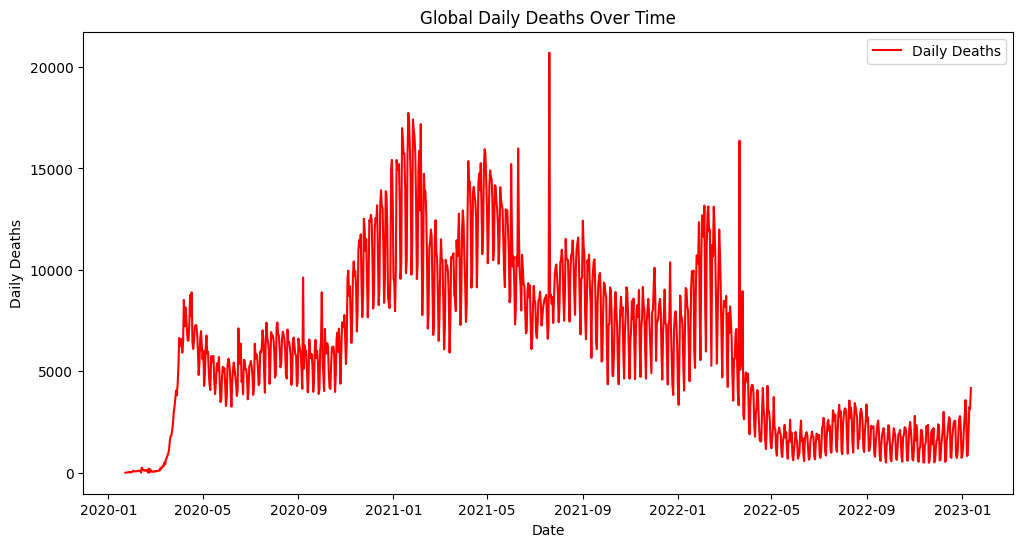

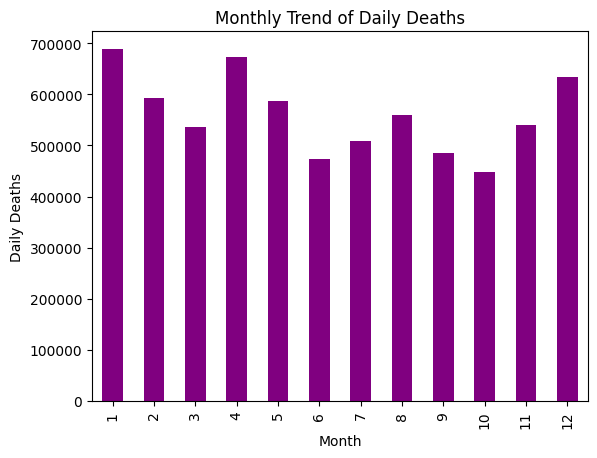

In [18]:
# Global daily deaths over time
global_trend = data.groupby('date')['daily_deaths'].sum()

plt.figure(figsize=(12, 6))
plt.plot(global_trend, label='Daily Deaths', color='red')
plt.title("Global Daily Deaths Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Deaths")
plt.legend()
plt.show()

# Monthly trend
monthly_trend = data.groupby('month')['daily_deaths'].sum()

monthly_trend.plot(kind='bar', color='purple')
plt.title("Monthly Trend of Daily Deaths")
plt.ylabel("Daily Deaths")
plt.xlabel("Month")
plt.show()


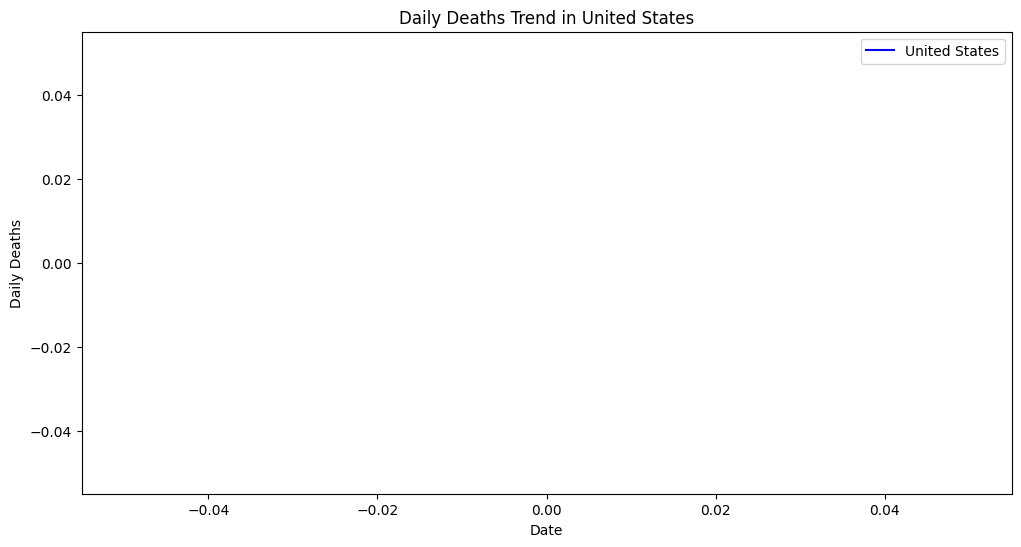

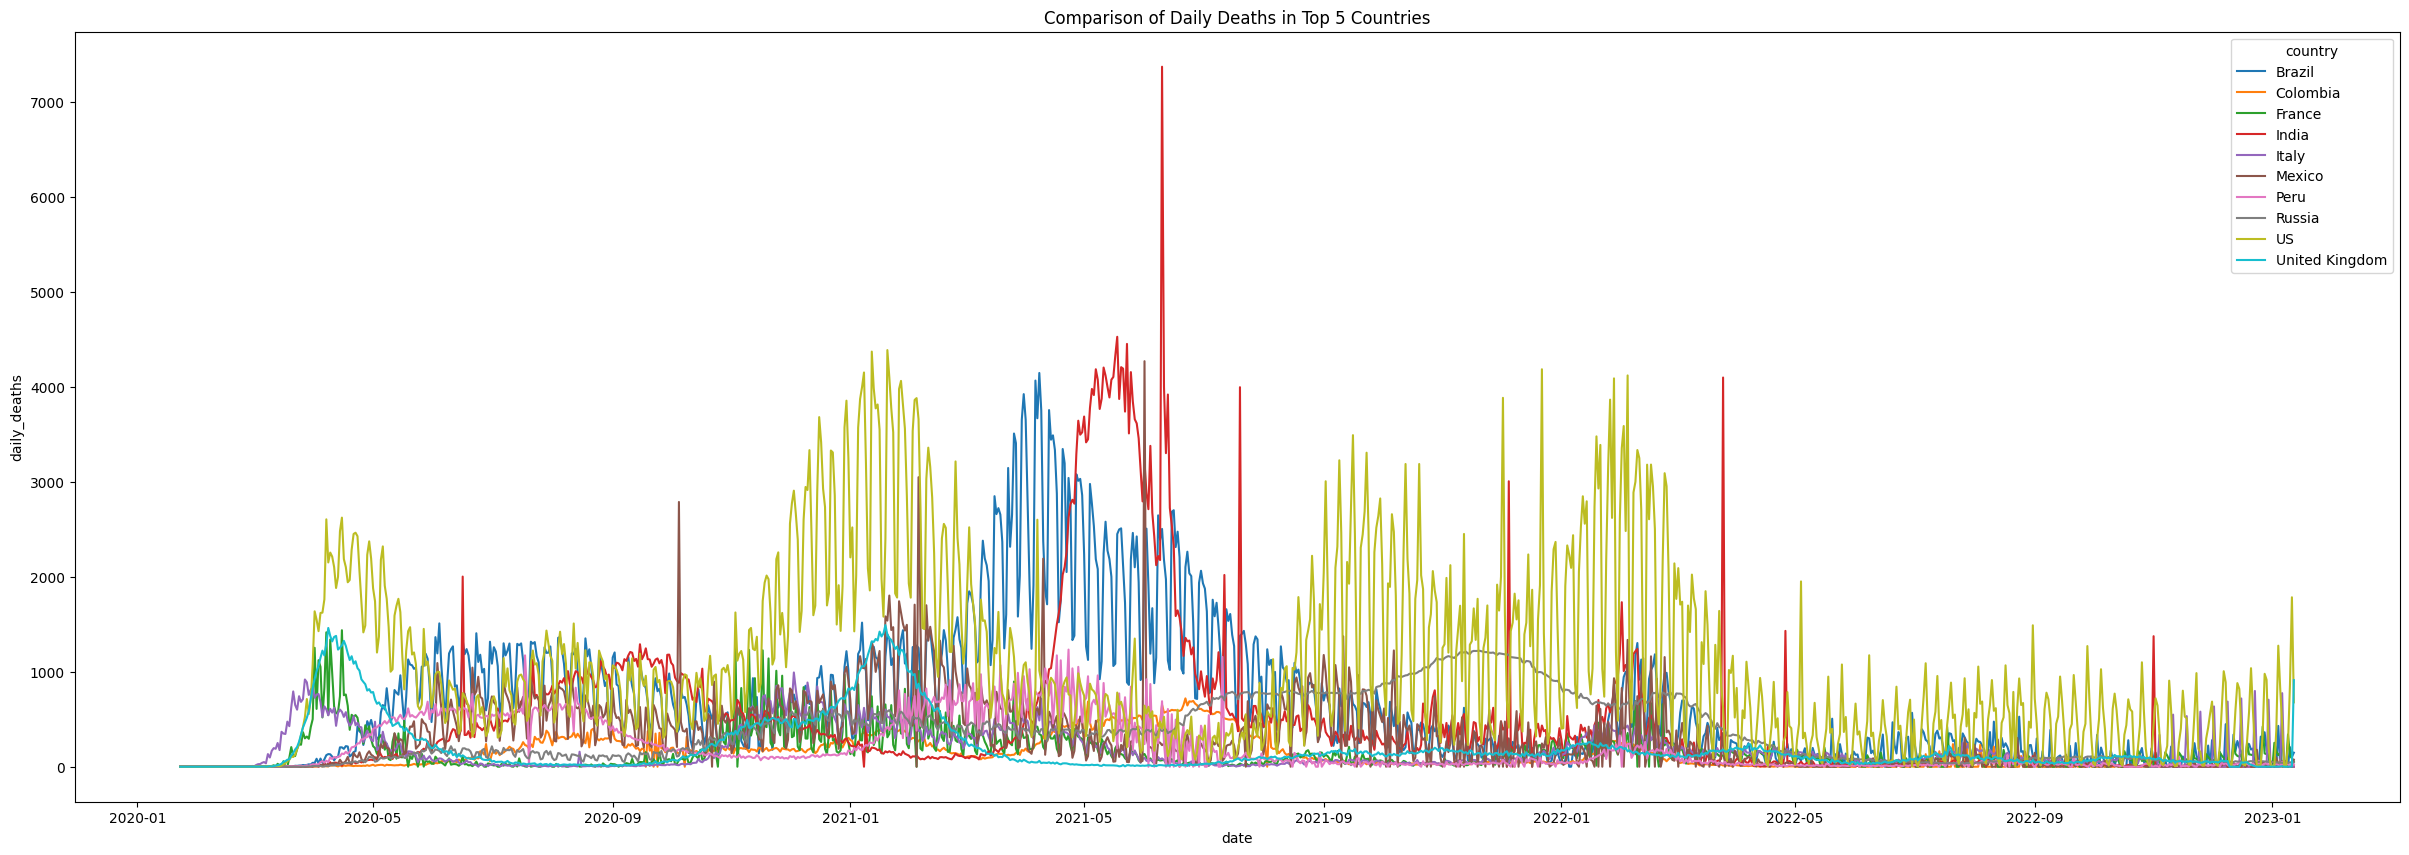

In [19]:
# Filter for a specific country
selected_country = 'United States'  # Replace with any country
country_data = data[data['country'] == selected_country]

plt.figure(figsize=(12, 6))
plt.plot(country_data['month'], country_data['daily_deaths'], label=selected_country, color='blue')
plt.title(f"Daily Deaths Trend in {selected_country}")
plt.xlabel("Date")
plt.ylabel("Daily Deaths")
plt.legend()
plt.show()

# Compare top 5 countries
top_countries_list = country_deaths.head(10).index
top_countries_data = data[data['country'].isin(top_countries_list)]
plt.figure(figsize=(30,10))
sns.lineplot(data=top_countries_data, x='date', y='daily_deaths', hue='country')
plt.title("Comparison of Daily Deaths in Top 5 Countries")
plt.show()


       country  cluster
0  Afghanistan        0
1      Albania        0
2      Algeria        0
3      Andorra        0
4       Angola        0


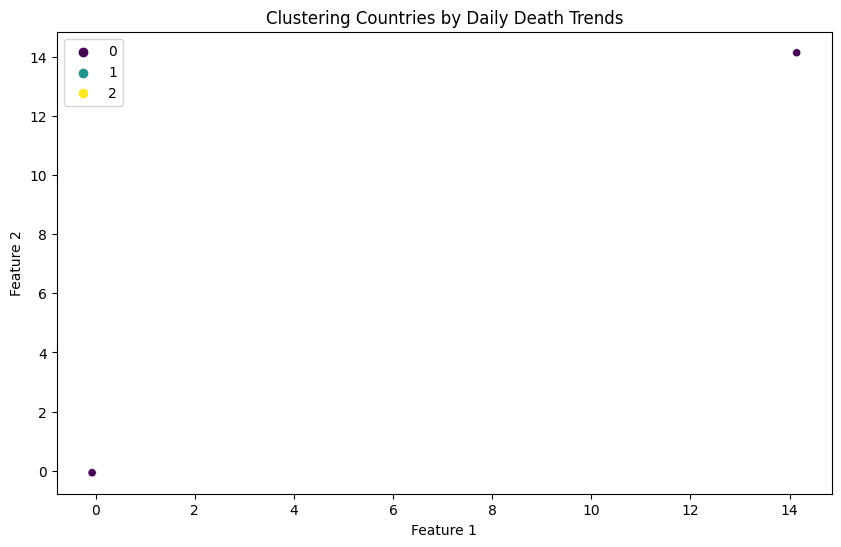

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Prepare data for clustering
daily_deaths_pivot = data.pivot_table(index='date', columns='country', values='daily_deaths', fill_value=0)
daily_deaths_scaled = StandardScaler().fit_transform(daily_deaths_pivot.T)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust clusters as needed
clusters = kmeans.fit_predict(daily_deaths_scaled)

# Add cluster labels to countries
country_clusters = pd.DataFrame({'country': daily_deaths_pivot.columns, 'cluster': clusters})

print(country_clusters.head())

# Visualize clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=daily_deaths_scaled[:, 0], y=daily_deaths_scaled[:, 1], hue=clusters, palette='viridis')
plt.title("Clustering Countries by Daily Death Trends")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


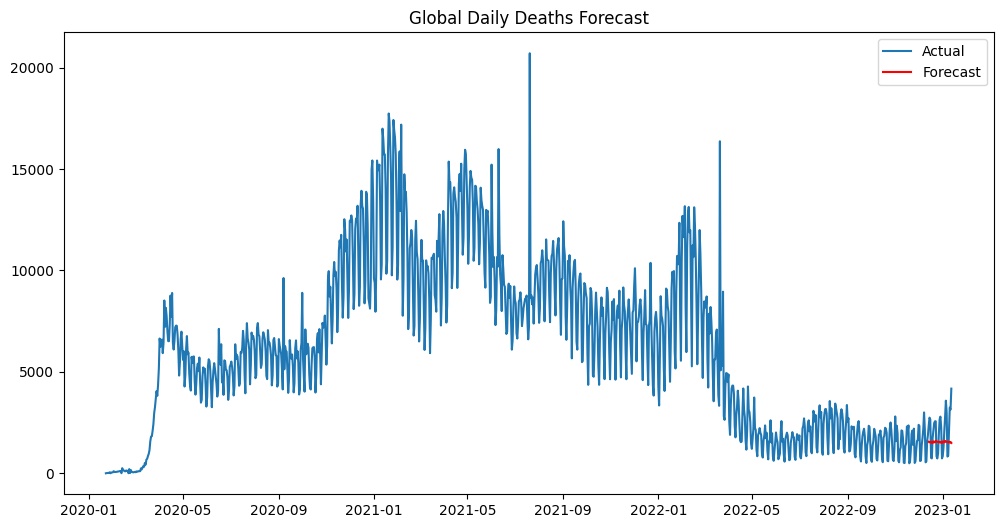

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Aggregate global daily deaths
global_daily_deaths = data.groupby('date')['daily_deaths'].sum()

# Train-test split
train_data = global_daily_deaths[:-30]  # Use all but last 30 days for training
test_data = global_daily_deaths[-30:]  # Use the last 30 days for testing

# Fit the model
model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit()

# Forecast
forecast = model.forecast(steps=30)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(global_daily_deaths, label='Actual')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title("Global Daily Deaths Forecast")
plt.legend()
plt.show()


country
Albania        850.996106
India          223.662227
Afghanistan    107.520739
Name: deaths_per_million, dtype: float64


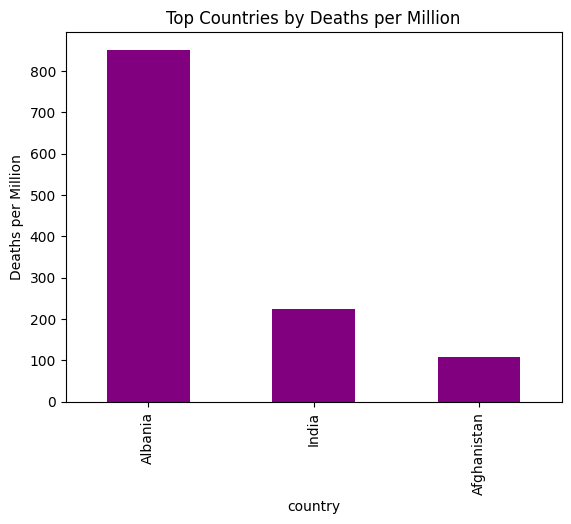

In [22]:
# Example population data (replace with actual data)
population_data = {
    'United States': 331002651,
    'India': 1380004385,
    'Afghanistan': 42647492,
    'Albania': 2471345
}

# Merge population data
data['population'] = data['country'].map(population_data)

# Calculate deaths per million
data['deaths_per_million'] = (data['deaths'] / data['population']) * 1e6

# Average deaths per million by country
avg_deaths_per_million = data.groupby('country')['deaths_per_million'].mean().sort_values(ascending=False)
print(avg_deaths_per_million.head(3))

# Plot top countries
avg_deaths_per_million.head(3).plot(kind='bar', color='purple')
plt.title("Top Countries by Deaths per Million")
plt.ylabel("Deaths per Million")
plt.show()


# Time Series Forecasting with Random Forest

Countries with Peak Daily Deaths:
country
Chile         11447.0
Ecuador        8786.0
India          7374.0
US             4389.0
Mexico         4272.0
Brazil         4148.0
Argentina      3351.0
Kazakhstan     2291.0
Indonesia      2069.0
Bolivia        1656.0
Name: daily_deaths, dtype: float64


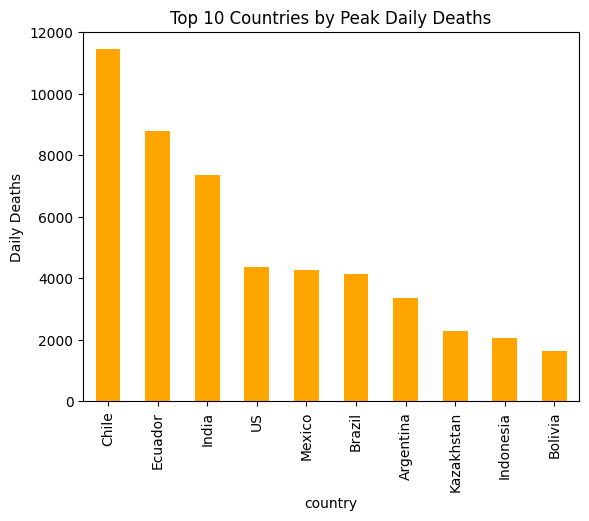

Global peak occurred on 2021-07-20 00:00:00 with 20702 deaths.


In [24]:
# Find countries with peak daily deaths
peak_daily_deaths = data.groupby('country')['daily_deaths'].max().sort_values(ascending=False)
print("Countries with Peak Daily Deaths:")
print(peak_daily_deaths.head(10))

# Visualize the peak deaths by country
peak_daily_deaths.head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Countries by Peak Daily Deaths")
plt.ylabel("Daily Deaths")
plt.show()

# Identify global peak dates
global_peak_date = global_daily_deaths.idxmax()
global_peak_value = global_daily_deaths.max()
print(f"Global peak occurred on {global_peak_date} with {global_peak_value:.0f} deaths.")


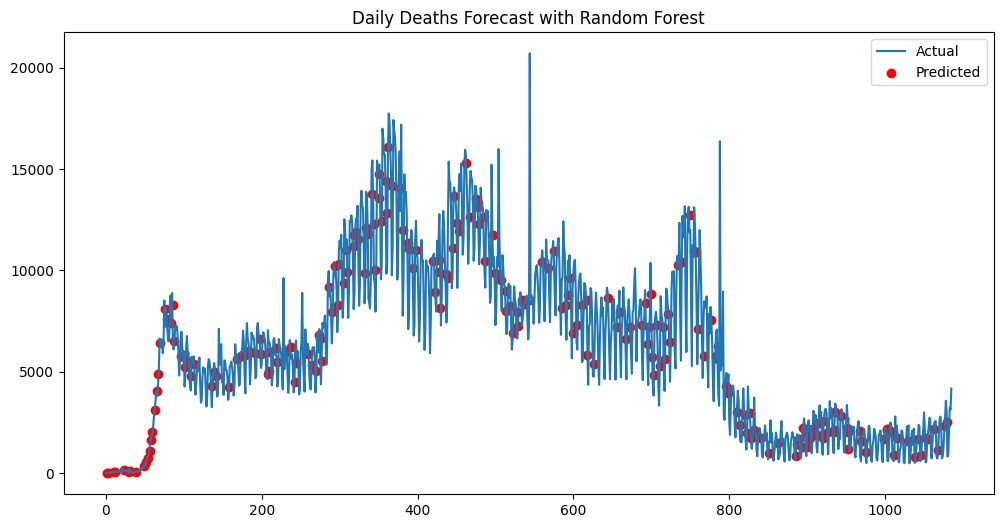

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare data for ML-based forecasting
global_daily_deaths = data.groupby('date')['daily_deaths'].sum().reset_index()
global_daily_deaths['date'] = pd.to_datetime(global_daily_deaths['date'])
global_daily_deaths['days_since_start'] = (global_daily_deaths['date'] - global_daily_deaths['date'].min()).dt.days

X = global_daily_deaths[['days_since_start']]
y = global_daily_deaths['daily_deaths']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(global_daily_deaths['days_since_start'], global_daily_deaths['daily_deaths'], label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.title("Daily Deaths Forecast with Random Forest")
plt.legend()
plt.show()
